In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime as dt
from pmdarima import auto_arima

C:\Users\ragha\AppData\Local\Temp\ipykernel_23492\3455530429.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').ffill()  # Forward-fill missing timestamps
C:\Users\ragha\AppData\Local\Temp\ipykernel_23492\3455530429.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_consumption = data['power_value'].resample('H').sum()


       power_value
count   757.000000
mean     66.113606
std     122.676038
min       0.000000
25%       0.000000
50%       0.000000
75%      32.000000
max     544.000000


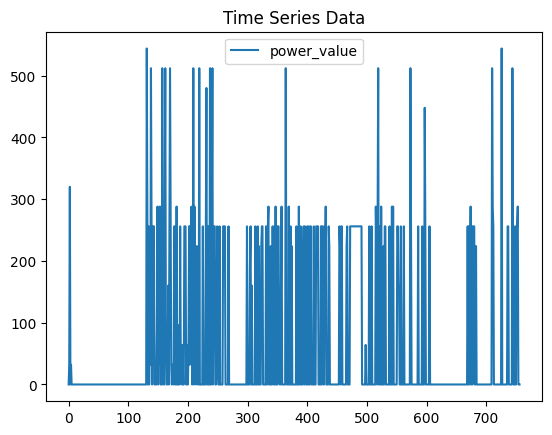

In [2]:
# Read the data
data = pd.read_csv('../datasets/power-meter-nov-data.csv')

# Convert the 'data.createdAt' column to datetime
data['data.createdAt'] = pd.to_datetime(data['data.createdAt'])

# Convert to IST
data['data.createdAt'] = data['data.createdAt'].dt.tz_convert('Asia/Kolkata')

# Remove duplicate timestamps
data = data.drop_duplicates(subset='data.createdAt')

# Sort the data by datetime
data = data.sort_values(by='data.createdAt').reset_index(drop=True)

# Set 'data.createdAt' as the index
data.set_index('data.createdAt', inplace=True)

# Calculate the difference in power values
data['power_value'] = data['data.value'].diff()

# Resample the data to fill missing timestamps
data = data.resample('H').ffill()  # Forward-fill missing timestamps
# data = data.resample('H').interpolate()

# Resample the data to hourly consumption
hourly_consumption = data['power_value'].resample('H').sum()

# Reset the index for a cleaner DataFrame
hourly_consumption_df = hourly_consumption.reset_index()
hourly_consumption_df.columns = ['date.createdAt', 'power_value']

time_series_data = hourly_consumption_df['power_value']

# time_series_data_scaled = scaler.fit_transform(time_series_data.values.reshape(-1, 1))
time_series_data_scaled = time_series_data.values

# Convert the scaled data back to a DataFrame
time_series_data_scaled = pd.DataFrame(time_series_data_scaled, index=time_series_data.index, columns=['power_value'])

# Display the summary statistics and plot to understand the data
print(time_series_data_scaled.describe())
time_series_data_scaled.plot(title="Time Series Data")
plt.show()

In [128]:
hourly_consumption_df.to_csv('../datasets/daily_consumption.csv', index=False)

In [129]:
hourly_consumption_df.describe()

,power_value
count,757.000000
mean,66.113606
std,122.676038
min,0.000000
25%,0.000000
50%,0.000000
75%,32.000000
max,544.000000


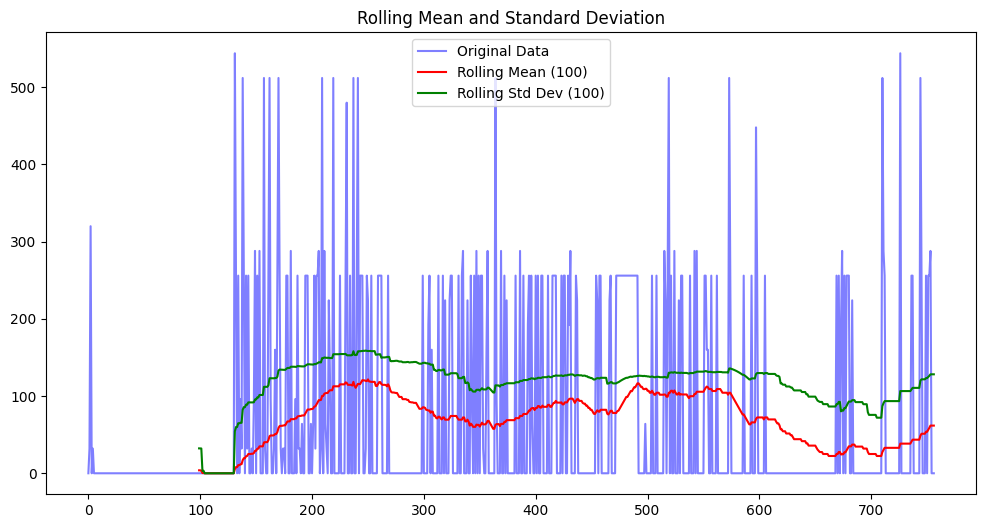

{'Test Statistic': -5.099799631419383,
 'p-value': 1.403200646712615e-05,
 'Lags Used': 9,
 'Number of Observations': 747}

In [130]:
# Perform a rolling mean and standard deviation analysis
rolling_mean = time_series_data_scaled.rolling(window=100).mean()
rolling_std = time_series_data_scaled.rolling(window=100).std()

# Plot the rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_scaled, label='Original Data', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean (100)', color='red')
plt.plot(rolling_std, label='Rolling Std Dev (100)', color='green')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()

# Perform the Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(time_series_data.dropna())
adf_results = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations': adf_test[3]
}
adf_results

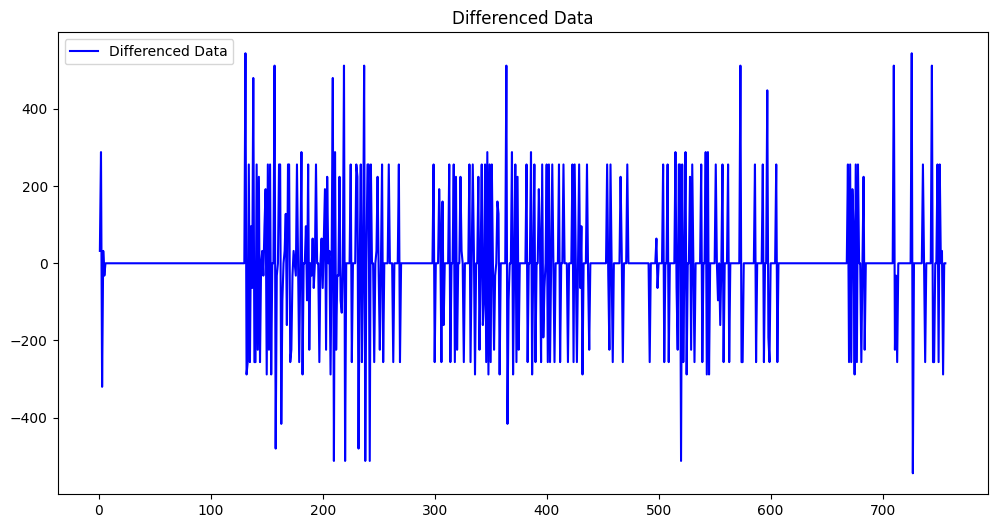

{'Test Statistic': -13.686574892096928,
 'p-value': 1.3688002644191724e-25,
 'Lags Used': 10,
 'Number of Observations': 745}

In [131]:
# Differencing the resampled data to make it stationary
differenced_data = time_series_data.diff().dropna()

# Perform the ADF test again after differencing
adf_test_diff = adfuller(differenced_data)
adf_results_diff = {
    'Test Statistic': adf_test_diff[0],
    'p-value': adf_test_diff[1],
    'Lags Used': adf_test_diff[2],
    'Number of Observations': adf_test_diff[3]
}

# Plot the differenced data to observe stationarity visually
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label='Differenced Data', color='blue')
plt.title('Differenced Data')
plt.legend()
plt.show()

adf_results_diff


The test statistic is significantly negative, and the p-value is well below 0.05, indicating that the differenced data is now stationary.

### Autocorrelation and Durbin-Watson Test

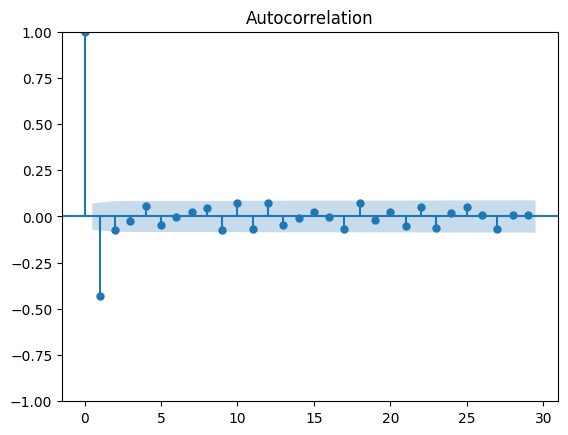

In [132]:
plot_acf(differenced_data, alpha=0.05)
plt.show()

In [133]:
time_series_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   power_value  757 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


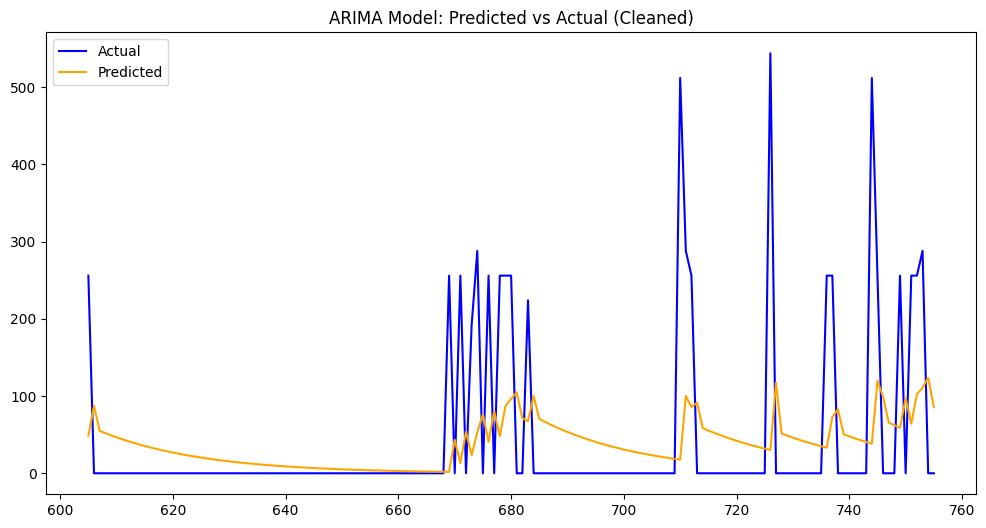

{'Mean Squared Error': 11260.012772506072,
 'Mean Absolute Error': 63.775266822175915,
 'Root Mean Squared Error': 106.1132073424702,
 'R-Squared': 0.05521182182861306}

In [134]:
# Train an ARIMA model (auto p, d, q selected for simplicity in initial test)
arima_order = (1, 1, 1)  # Initial values, adjustable based on tuning
arima_model = ARIMA(time_series_data, order=arima_order)
arima_fitted = arima_model.fit()

# Generate predictions
pred_start = time_series_data.index[int(0.8 * len(time_series_data))]  # 80% training, 20% test split
pred_end = time_series_data.index[-1]
arima_predictions = arima_fitted.predict(start=pred_start, end=pred_end, typ='levels')

# # Evaluate metrics
actual_values = time_series_data[pred_start:pred_end]

# Drop NaN values from the actual values to align with predictions
actual_values_cleaned = actual_values.dropna()

# Align predictions to the cleaned actual values index
aligned_predictions = arima_predictions.loc[actual_values_cleaned.index]

mse = mean_squared_error(actual_values_cleaned, aligned_predictions)
mae = mean_absolute_error(actual_values_cleaned, aligned_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values_cleaned, aligned_predictions)

# Plot actual vs predicted values again
plt.figure(figsize=(12, 6))
plt.plot(actual_values_cleaned, label='Actual', color='blue')
plt.plot(aligned_predictions, label='Predicted', color='orange')
plt.title('ARIMA Model: Predicted vs Actual (Cleaned)')
plt.legend()
plt.show()

# Metrics report
arima_metrics_cleaned = {
    'Mean Squared Error': mse,
    'Mean Absolute Error': mae,
    'Root Mean Squared Error': rmse,
    'R-Squared': r2
}
arima_metrics_cleaned


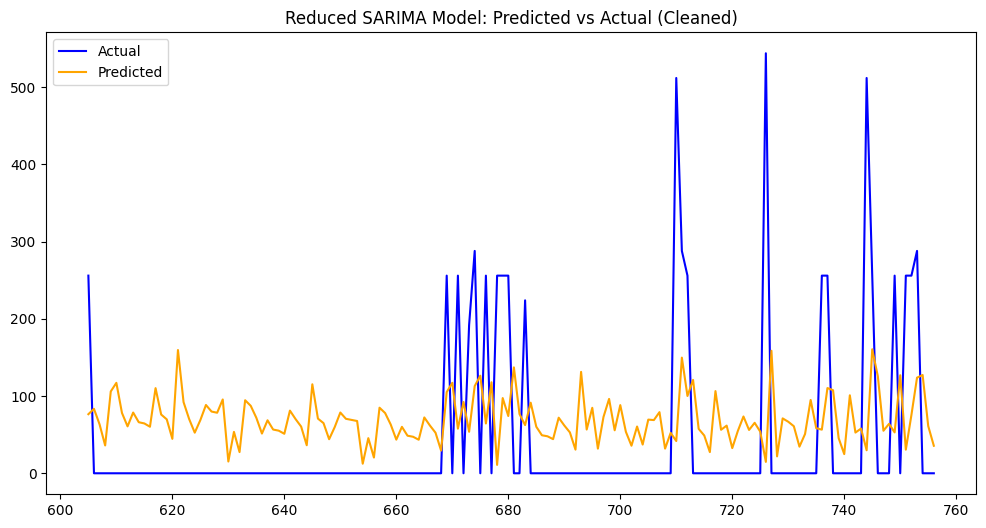

{'Mean Squared Error': 13407.656865533145,
 'Mean Absolute Error': 89.8799533672149,
 'Root Mean Squared Error': 115.79143692662745,
 'R-Squared': -0.1313066168108019}

In [135]:
sarima_order = (1, 1, 1)  # ARIMA order
seasonal_order = (1, 1, 1, 24)  # Seasonal order with 24-hour seasonality

reduced_data = time_series_data # Use the last 1000 data points

# Train the SARIMA model on reduced data
sarima_model_reduced = SARIMAX(reduced_data, order=sarima_order, seasonal_order=seasonal_order)
sarima_fitted_reduced = sarima_model_reduced.fit(disp=False)

# Generate predictions for reduced data
sarima_predictions_reduced = sarima_fitted_reduced.predict(start=reduced_data.index[int(0.8 * len(reduced_data))], 
                                                           end=reduced_data.index[-1], typ='levels')

# Align reduced predictions with actual values
actual_values_reduced = reduced_data[sarima_predictions_reduced.index[0]:]
sarima_predictions_reduced_aligned = sarima_predictions_reduced.loc[actual_values_reduced.index]

# Drop NaN values from the reduced actual values to align with predictions
actual_values_reduced_cleaned = actual_values_reduced.dropna()

# Align predictions to the cleaned actual values index
aligned_predictions_reduced = sarima_predictions_reduced.loc[actual_values_reduced_cleaned.index]

# Recalculate metrics for the reduced SARIMA model
mse_sarima_reduced = mean_squared_error(actual_values_reduced_cleaned, aligned_predictions_reduced)
mae_sarima_reduced = mean_absolute_error(actual_values_reduced_cleaned, aligned_predictions_reduced)
rmse_sarima_reduced = np.sqrt(mse_sarima_reduced)
r2 = r2_score(actual_values_reduced_cleaned, aligned_predictions_reduced)

# Plot actual vs predicted values for the reduced SARIMA model
plt.figure(figsize=(12, 6))
plt.plot(actual_values_reduced_cleaned, label='Actual', color='blue')
plt.plot(aligned_predictions_reduced, label='Predicted', color='orange')
plt.title('Reduced SARIMA Model: Predicted vs Actual (Cleaned)')
plt.legend()
plt.show()

# Metrics report for the reduced SARIMA model
sarima_metrics_reduced_cleaned = {
    'Mean Squared Error': mse_sarima_reduced,
    'Mean Absolute Error': mae_sarima_reduced,
    'Root Mean Squared Error': rmse_sarima_reduced,
    'R-Squared': r2
}
sarima_metrics_reduced_cleaned

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=11.00 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=9764.829, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=9614.914, Time=0.61 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9372.110, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=9762.830, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=9370.142, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=9372.113, Time=1.62 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=9364.979, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=9366.941, Time=2.97 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=9366.935, Time=3.41 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=8.81 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=9613.239, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=9366.250, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[24] intercep

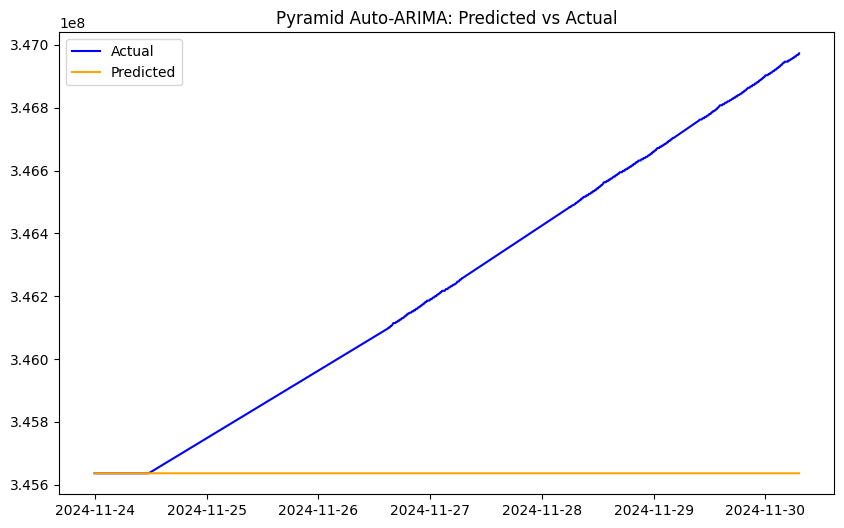

In [136]:
# Train Auto-ARIMA model
auto_arima_model = auto_arima(
    time_series_data.dropna(),
    seasonal=True,
    m=24,  # Adjust this based on the seasonality of your data
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

# Split the data for training and testing
train_size = int(0.8 * len(resampled_data))
train, test = resampled_data[:train_size], resampled_data[train_size:]

# Fit the model on training data
auto_arima_model.fit(train)

# Generate predictions
predictions = pd.Series(auto_arima_model.predict(n_periods=len(test)), index=test.index)

# Drop NaN values from the reduced actual values to align with predictions
test = test.dropna()

# Align predictions to the cleaned actual values index
predictions = predictions.loc[test.index]

# Evaluate model
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R2: {r2_score(test, predictions)}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('Pyramid Auto-ARIMA: Predicted vs Actual')
plt.legend()
plt.show()

In [137]:
seasonal_decompose(hourly_consumption_df['power_value'], model ='multiplicative', period=60).plot()

NameError: name 'seasonal_decompose' is not defined

### Linear Models

In [139]:
# Lag-based feature engineering for time series
def create_lag_features(series, lags=5):
    # Ensure the input is a Series and not a DataFrame
    if isinstance(series, pd.DataFrame):
        raise ValueError("Input `series` must be a pandas Series, not a DataFrame.")
    
    data = pd.DataFrame(series)
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = series.shift(lag)
    data.dropna(inplace=True)
    return data

# Prepare features and target
lagged_data = create_lag_features(hourly_consumption_df['power_value'], lags=3)
# # Add datetime features
# lagged_data['day_of_week'] = data.index.dayofweek
# lagged_data['hour'] = data.index.hour
# lagged_data['datetime_ordinal'] = data.index.to_series().apply(lambda x: x.toordinal())

# Separate features and target
X = lagged_data.drop(columns=['power_value'])
y = lagged_data['power_value']

# Split into training and testing sets
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [140]:
# Dictionary of models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'BayesianRidge': BayesianRidge(),
    'HuberRegressor': HuberRegressor(),
    'SGDRegressor': SGDRegressor(max_iter=1000, tol=1e-3),
    'TheilSenRegressor': TheilSenRegressor()
}

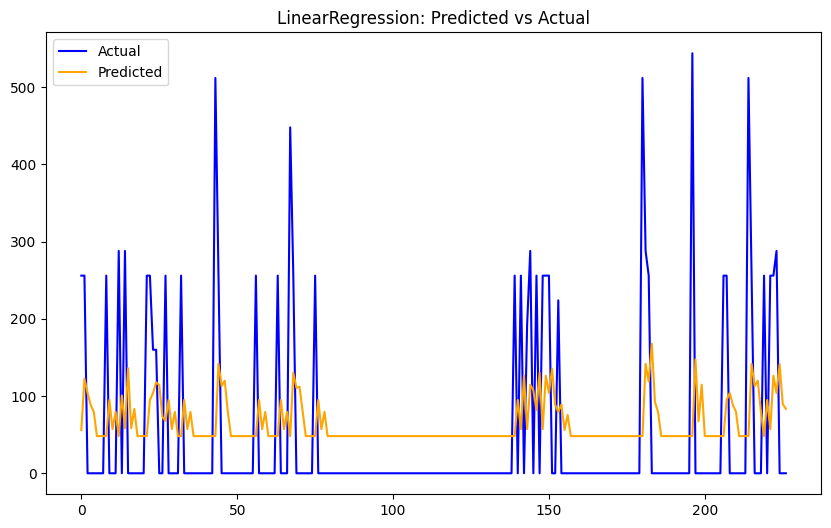

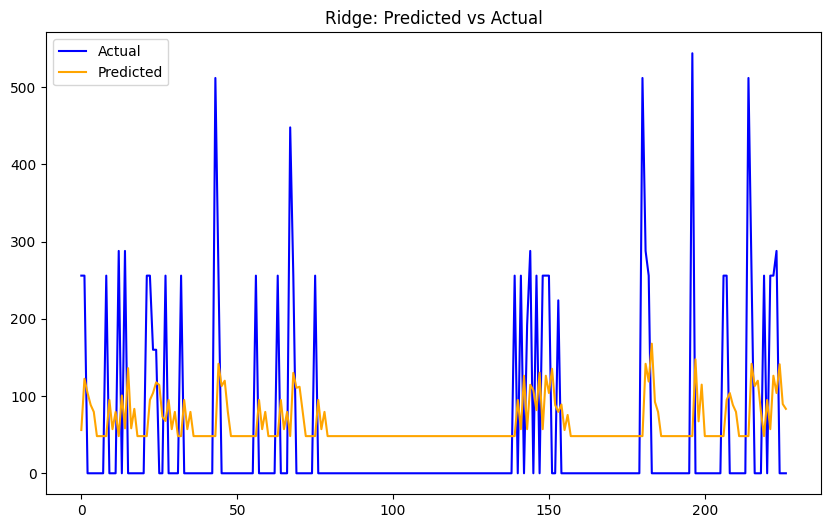

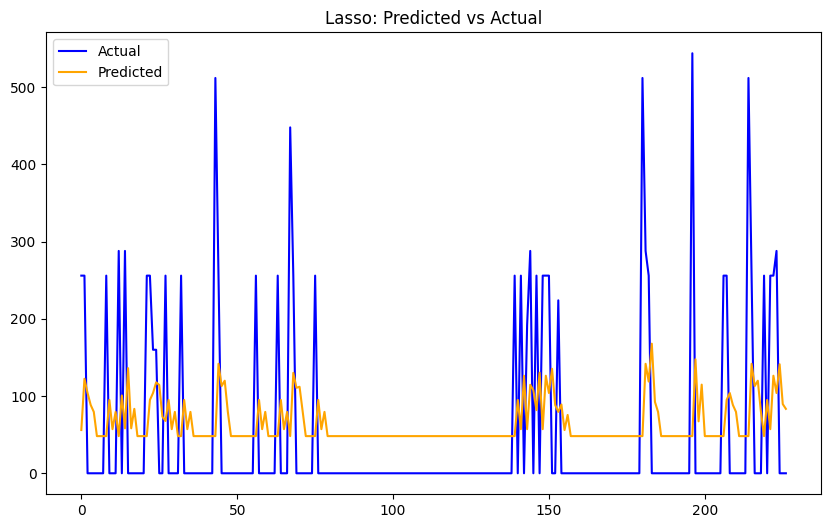

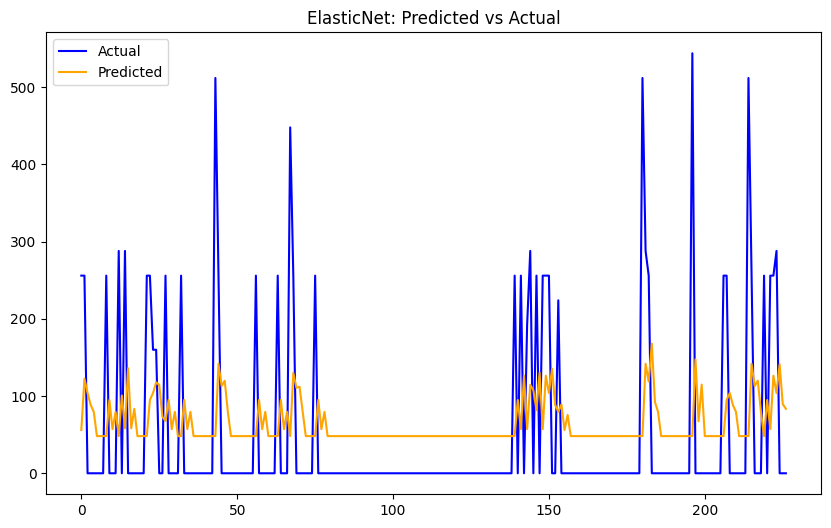

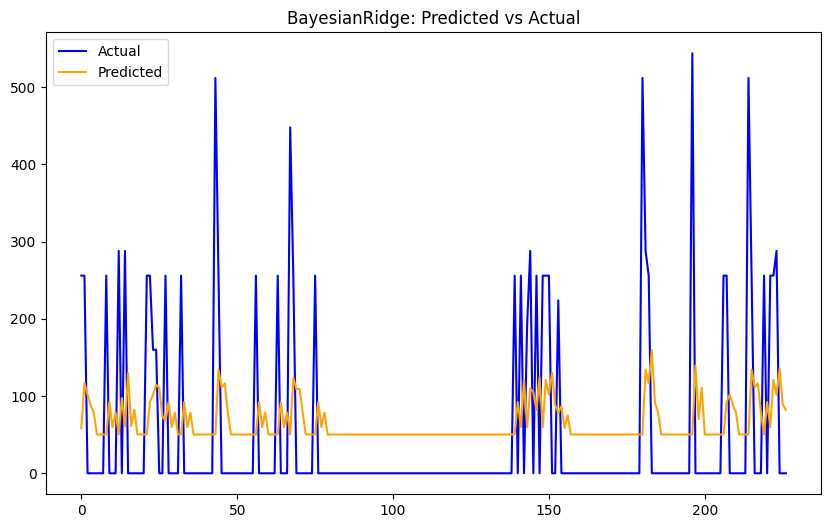

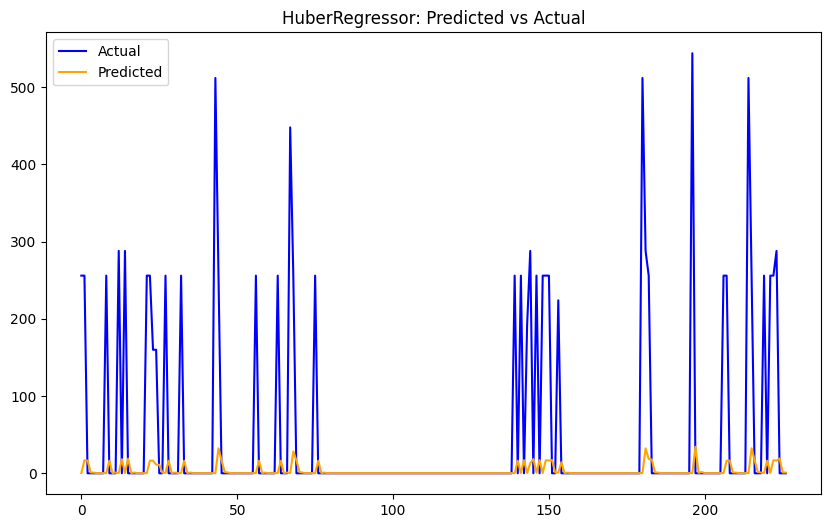

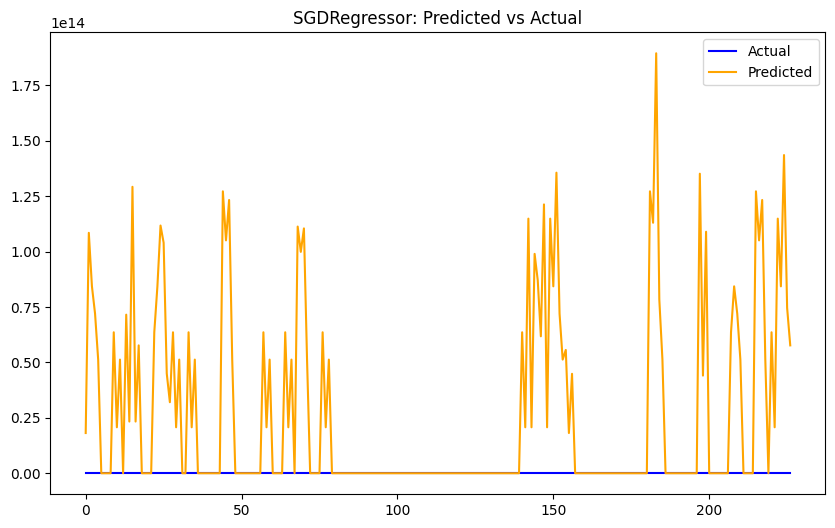

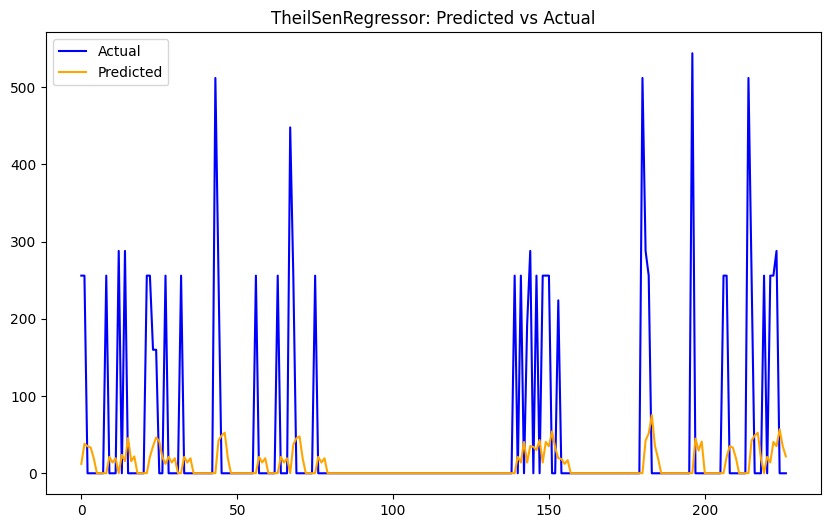

LinearRegression:
  MSE: 12919.3363
  MAE: 86.7538
  RMSE: 113.6633
  R2: -0.0005
Ridge:
  MSE: 12919.3363
  MAE: 86.7538
  RMSE: 113.6633
  R2: -0.0005
Lasso:
  MSE: 12919.3246
  MAE: 86.7542
  RMSE: 113.6632
  R2: -0.0005
ElasticNet:
  MSE: 12919.3297
  MAE: 86.7541
  RMSE: 113.6632
  R2: -0.0005
BayesianRidge:
  MSE: 12902.9257
  MAE: 87.6284
  RMSE: 113.5910
  R2: 0.0008
HuberRegressor:
  MSE: 14677.7510
  MAE: 49.6457
  RMSE: 121.1518
  R2: -0.1367
SGDRegressor:
  MSE: 2404592927176816202136682496.0000
  MAE: 26195887086830.7734
  RMSE: 49036648816745.3828
  R2: -186213978667513502760960.0000
TheilSenRegressor:
  MSE: 14118.3986
  MAE: 53.2721
  RMSE: 118.8209
  R2: -0.0933


In [141]:
# Train and evaluate each model
results = {}
predictions_dict = {}

for name, model in models.items():
    try:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        predictions = model.predict(X_test)
        predictions_dict[name] = predictions.flatten()
        # Evaluate metrics
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        results[name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.values, label='Actual', color='blue')
        plt.plot(predictions, label='Predicted', color='orange')
        plt.title(f'{name}: Predicted vs Actual')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error training {name}: {e}")

# Display metrics for all models
for model, metrics in results.items():
    print(f"{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

In [95]:
predictions_dict

{'LinearRegression': array([ 56.00772576, 122.42553267, 103.9684993 ,  88.51526742,
         79.51284211,  48.13060361,  48.13060361,  48.13060361,
         48.13060361,  94.96607398,  57.13302892,  79.51284211,
         48.13060361, 100.82050778,  58.25833209, 136.12552609,
         58.25833209,  83.43562192,  48.13060361,  48.13060361,
         48.13060361,  48.13060361,  94.96607398, 103.9684993 ,
        117.78743641, 114.41152691,  73.37101849,  67.74450267,
         94.96607398,  57.13302892,  79.51284211,  48.13060361,
         48.13060361,  94.96607398,  57.13302892,  79.51284211,
         48.13060361,  48.13060361,  48.13060361,  48.13060361,
         48.13060361,  48.13060361,  48.13060361,  48.13060361,
        141.80154436, 112.97092461, 119.89750592,  79.51284211,
         48.13060361,  48.13060361,  48.13060361,  48.13060361,
         48.13060361,  48.13060361,  48.13060361,  48.13060361,
         48.13060361,  94.96607398,  57.13302892,  79.51284211,
         48.13060361

In [96]:
pred_df = pd.DataFrame(predictions_dict)
pred_df['actual'] = y_test.values
pred_df['date'] = X_test['data.createdAt'].map(dt.datetime.fromordinal)

KeyError: 'data.createdAt'

In [ ]:
pred_df.to_csv('../datasets/predictions.csv', index=False)

In [97]:
X_test

,lag_1,lag_2,lag_3
530,0.0,224.0,0.0
531,256.0,0.0,224.0
532,256.0,256.0,0.0
533,0.0,256.0,256.0
534,0.0,0.0,256.0
...,...,...,...
752,256.0,0.0,256.0
753,256.0,256.0,0.0
754,288.0,256.0,256.0
755,0.0,288.0,256.0


In [35]:
y_test

data.createdAt
2024-11-20 23:22:20.728000+00:00    344962272
2024-11-20 23:22:59.729000+00:00    344962272
2024-11-20 23:23:38.742000+00:00    344962272
2024-11-20 23:24:17.756000+00:00    344962272
2024-11-20 23:24:56.762000+00:00    344962272
                                      ...    
2024-10-30 08:27:01.823000+00:00    341309440
2024-10-30 08:27:37.779000+00:00    341309440
2024-10-30 08:28:13.740000+00:00    341309440
2024-10-30 08:28:49.691000+00:00    341309440
2024-10-30 08:29:25.645000+00:00    341309440
Name: data.value, Length: 14863, dtype: int64